# DC2 object Run1.1p Apache Spark tutorial -- Part I: Apache Spark access

Author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Based on the work of: **Francois Lanusse [@EiffL](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@EiffL), Javier Sanchez [@fjaviersanchez](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@fjaviersanchez)** using GCR.  
Last Verifed to Run: **2018-10-22**

This notebook will illustrate the basics of accessing the merged object catalogs through Apache Spark as well as how to select useful samples of stars/galaxies from the dpdd catalogs (from DM outputs). It follows the same steps (and sometimes same documentation) as in this [notebook](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_1_intro.ipynb) which uses the Generic Catalog Reader ([GCR](https://github.com/yymao/generic-catalog-reader)).

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Load and efficiently access a DC2 object catalog with Apache Spark
  2. Understand and have references for the catalog schema
  3. Apply cuts to the catalog using Spark SQL functionalities
  4. Have an example of quality cuts and simple star/galaxy separation cut
  5. Distribute the computation and the routine to plot to be faster!

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC [interface](https://jupyter-dev.nersc.gov) with the `desc-pyspark` kernel. The kernel is automatically installed in your environment when you use the kernel setup script:

```
source /global/common/software/lsst/common/miniconda/kernels/setup.sh
```

For more information see [LSSTDESC/jupyter-kernels](https://github.com/LSSTDESC/jupyter-kernels). Note that a general introduction and tutorials for Apache Spark can be found at [astrolabsoftware/spark-tutorials](https://github.com/astrolabsoftware/spark-tutorials) (under construction).

__Note concerning resources__

```
The large-memory login node used by https://jupyter-dev.nersc.gov/
is a shared resource, so please be careful not to use too many CPUs
or too much memory.

That means avoid using `--master local[*]` in your kernel, but limit
the resources to a few core. Typically `--master local[4]` is enough for
prototyping a program.

Then to scale the analysis, the best is to switch to batch mode! 
There, no limit!
```

This is already taken care for you in the Spark+DESC kernel setup script (from `desc-pyspark`), but keep this in mind if you use a custom kernel.

In [26]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt

## Accessing the object catalog with Apache Spark

In this section, we illustrate how to use Apache Spark to access the object catalogs from DC2 Run1.1p.
Let's initialise Spark and load the data into a DataFrame. We will focus on data stored in the `parquet` data format.

In [27]:
! ls /global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary | grep dpdd_object.parquet

dpdd_object.parquet


In [28]:
# Where the dpdd data is stored
base_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary'

# Load one patch, all tracts
datafile = os.path.join(base_dir, 'dpdd_object.parquet')
print("Data will be read from: \n", datafile)

Data will be read from: 
 /global/projecta/projectdirs/lsst/global/in2p3/Run1.1/summary/dpdd_object.parquet


In [29]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

# Read the data as DataFrame
df = spark.read.format("parquet").load(datafile)

### DC2 Object catalog Schema


To see the quantities available in the catalog, you can use the following:

In [30]:
# Check what we have in the file
df.printSchema()

root
 |-- magerr_i: double (nullable = true)
 |-- psFlux_i: double (nullable = true)
 |-- Ixx_r: double (nullable = true)
 |-- mag_i_cModel: double (nullable = true)
 |-- IxxPSF_u: double (nullable = true)
 |-- magerr_r: double (nullable = true)
 |-- psf_fwhm_i: double (nullable = true)
 |-- psf_fwhm_r: double (nullable = true)
 |-- Ixx: double (nullable = true)
 |-- magerr_g_cModel: double (nullable = true)
 |-- I_flag_y: boolean (nullable = true)
 |-- Iyy_z: double (nullable = true)
 |-- IxyPSF_i: double (nullable = true)
 |-- Ixx_z: double (nullable = true)
 |-- magerr_u_cModel: double (nullable = true)
 |-- IxyPSF: double (nullable = true)
 |-- snr_u_cModel: double (nullable = true)
 |-- IxxPSF_y: double (nullable = true)
 |-- psFlux_flag_i: boolean (nullable = true)
 |-- IyyPSF_g: double (nullable = true)
 |-- Ixy: double (nullable = true)
 |-- magerr_y: double (nullable = true)
 |-- psFlux_g: double (nullable = true)
 |-- snr_y_cModel: double (nullable = true)
 |-- Ixy_z: double 

The meaning of these fields follows the standard nomenclature of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd).

The DPDD is an effort made by the LSST project to standardize the format of the official Data Release Products (DRP). While the native outputs of the DM stack are succeptible to change, the DPDD will be more stable. An early adoption of these conventions by the DESC will save time and energy down the road.

We can see that the catalog includes:

* Positions
* Fluxes and magnitudes (PSF and [CModel](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel))
* Shapes (using [GalSim's HSM](http://galsim-developers.github.io/GalSim/namespacegalsim_1_1hsm.html))
* Quality flags: e.g, does the source have any interpolated pixels? Has any of the measurement algorithms returned an error?
* Other useful quantities: `blendedness`, measure of how flux is affected by neighbors: (1 - flux.child/flux.parent) (see 4.9.11 of [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B)); `extendedness`, classifies sources in extended and psf-like.

### Accessing the data (taken from the original GCR notebook)

While Run1.1p is still of manageable size, full DC2 will be much larger, accessing the whole data can be challenging. In order to access the data efficiently, it is important to understand how it is physically stored and how to access it, one piece at the time. 


The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2:
<img src="assets/dc2_skymap.png">
Here the tracts have large blue numbers, and the patches are denoted with an `(x,y)` format. For DC2, each tract has 8x8 patches.

You can learn more about how to make such a plot of the tract and patches [here](Plotting_the_Run1.1p_skymap.ipynb)

Obviously Spark preserves the structure of the data so that any particular quantity can be accessed on a tract/patch bases. The tracts available in the catalog can be listed using the following command:

In [31]:
# Show all available tracts
df.select('tract').distinct().show()

+-----+
|tract|
+-----+
| 4637|
| 4848|
| 5066|
| 5062|
| 4851|
| 4639|
| 4852|
| 4849|
| 4638|
| 5064|
| 5065|
| 5063|
| 4431|
| 4433|
| 4432|
| 4640|
| 4636|
| 4850|
| 4430|
+-----+



In [ ]:
 data.describe().show()

The DM stack includes functionality to get the tract and patch number corresponding to a certain position `(RA,DEC)`. However, it is out of the scope of this tutorial.

Apache Spark provides `filter` mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset.
For the object catalog, the chunks are broken into `tract` and `patch`, and hence those are the `filters` you can use:

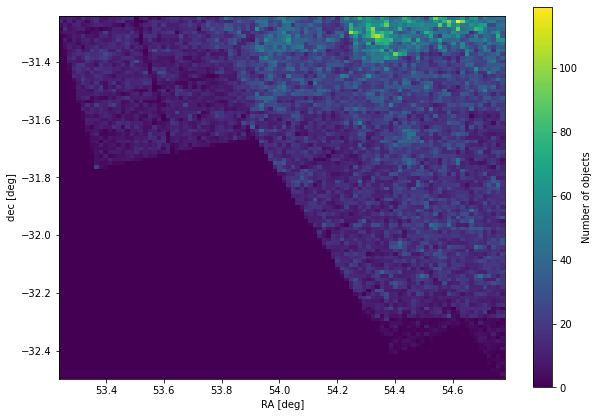

In [32]:
# Retrieve the ra,dec coordinates of all sources within tract number 4430
data = df.select('ra', 'dec').where('tract == 4430').collect()

# `collect` returns list of list[ra, dec], so for 
# plotting purpose we tranpose the output:
ra, dec = np.transpose(data)

# Plot a 2d histogram of sources
plt.figure(figsize=(10,7))
plt.hist2d(ra, dec, 100)
plt.gca().set_aspect('equal')
plt.colorbar(label='Number of objects')
plt.xlabel('RA [deg]')
plt.ylabel('dec [deg]');

It is interesting to note that there are several ways in Spark to use those filtering mechanisms

**Pure SQL**

In [33]:
# Pure SQL
cols = "ra, dec"

# SQL - register first the DataFrame
df.createOrReplaceTempView("full_tract")

# Keeps only columns with 0.0 < magerr_g < 0.3
sql_command = """
    SELECT {}
    FROM full_tract 
    WHERE 
        tract == 4430
""".format(cols)

# Execute the expression - return a DataFrame
df_sub = spark.sql(sql_command)
data = df_sub.collect()

**Spark DataFrame built-in methods**

In [34]:
# Using select/where
data = df.select('ra', 'dec').where('tract == 4430').collect()

# Or using select/filter
data = df.select('ra', 'dec').filter('tract == 4430').collect()

**Data type**

The data returned by collecting a DataFrame (`collect`) in Spark is structured as a native Python list of `Row`:

In [35]:
print("Data type is {}".format(type(data[0])))
print("Example: {}".format(data[0]))

Data type is <class 'pyspark.sql.types.Row'>
Example: Row(ra=54.404930306668895, dec=-31.365531039028056)


But you can easily go back to standard list or numpy array (numpy methods do that for you most of the time) is needed:

In [36]:
arow = data[0]

# Explicit conversion
mylist = list(arow)
print("input type: {} / output type {}".format(type(arow), type(mylist)))

# Implicit conversion
cols = np.transpose(arow)
print("input type: {} / output type {}".format(type(arow), type(cols)))

input type: <class 'pyspark.sql.types.Row'> / output type <class 'list'>
input type: <class 'pyspark.sql.types.Row'> / output type <class 'numpy.ndarray'>


**Spark to Pandas DataFrame**

A Spark DataFrame can also easily be converted into a [Pandas DataFrame](https://pandas.pydata.org):

In [37]:
pdata = df.select('ra', 'dec').where('tract == 4430').toPandas()
pdata

,ra,dec
0,54.404930,-31.365531
1,54.410349,-31.365466
2,54.487789,-31.364878
3,54.457632,-31.364972
4,54.414210,-31.364857
...,...,...
103882,54.410731,-32.395946
103883,54.413689,-32.395284
103884,54.429948,-32.394602
103885,54.394665,-32.403016


**Access time**

As a simple test, you can show the advantage of loading one tract at a time compared to the entire catalog:

In [38]:
df_radec = df.select('ra', 'dec')
%time data = df_radec.where('tract == 4430').collect()

CPU times: user 379 ms, sys: 12.4 ms, total: 391 ms
Wall time: 742 ms


In [39]:
%time data = df_radec.collect()

CPU times: user 23 s, sys: 2.05 s, total: 25.1 s
Wall time: 29.7 s


Note that we timed the `collect` action which is very specific (collecting data from the executors to the driver). In practice, we do not perform this action often (only at the very end of the pipeline, because it implies communication btw the machines). In Spark, we do most of the computation (including plot!) in the executors (distributed computation), and we collect the data once it is sufficiently reduced. Therefore, what matters more is the time to load the data and perform an action inside executors. The simplest one (but relevant though!) is to count the elements (O(n) complexity):

In [40]:
%time data = df_radec.where('tract == 4430').count()

CPU times: user 1.01 s, sys: 503 ms, total: 1.51 s
Wall time: 1.8 s


In [41]:
%time data = df_radec.count()

CPU times: user 0 ns, sys: 2.81 ms, total: 2.81 ms
Wall time: 3.89 s


Here we are, super fast! Note that we loaded the data AND perform a simple action. So these benchmarks give you the IO overhead for this kind of catalogs. More about Apache Spark benchmarks can be found [here](https://github.com/LSSTDESC/DC2-production/pull/288).

### Applying filters and cuts

For more than one cut, this is all the same:

In [42]:
# Simple cut to remove unreliable detections
# More cuts can be added, as a logical AND, by appending GCRQuery objects to this list
# good: 
#   The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
#   and was not skipped by the deblender
# tract == 4849:
#   Data only for tract 4849

# Data after cut (DataFrame)
df_cut = df_radec.where("tract == 4849 AND good")

# Data without cuts (DataFrame)
df_full = df_radec.where("tract == 4849")

In [43]:
print("Number of sources before cut : {}".format(df_full.count()))
print("Number of sources after cut  : {}".format(df_cut.count()))

Number of sources before cut : 785795
Number of sources after cut  : 780845


**Plotting the result - the standard way**

The standard way means filtering data, collecting data, and plotting (e.g. you would do that in GCR). This can be written as:

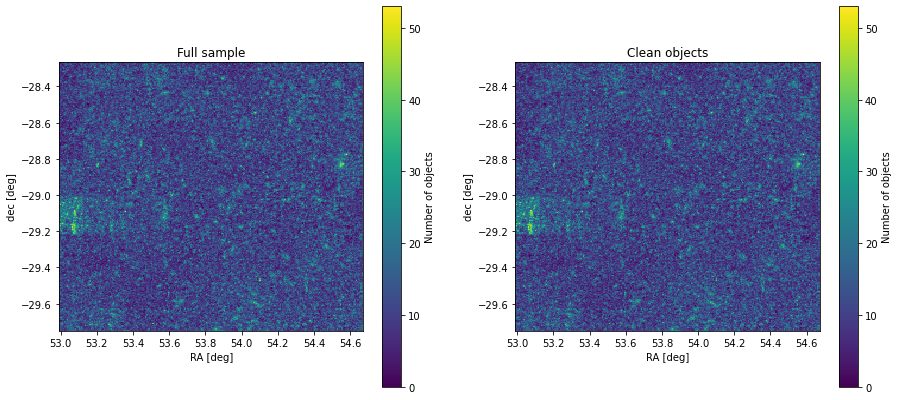

In [44]:
# Plot a 2d histogram of sources
plt.figure(figsize=(15, 7))
for index, dataframe in enumerate([df_full, df_cut]):
    ra, dec = np.transpose(dataframe.collect())
    plt.subplot(121 + index)
    (counts, xe, ye, Image) = plt.hist2d(ra, dec, 256); 
    plt.gca().set_aspect('equal'); 
    plt.xlabel('RA [deg]');
    plt.ylabel('dec [deg]');
    if index == 0:
        plt.title('Full sample');
    else:
        plt.title('Clean objects');
    plt.colorbar(label='Number of objects');

Now all of that works because you have only a small fraction of data. Let's imagine if you have TB of data, even after cuts. What would you do? GCR makes use of iterators. This is a workaround, but still not satisfactory as things are done _serially_. For TB of data it will work, but it will take forever. 

**Spark point of view: distribute the computation (and plot!)**

The way to be faster is to distribute the plot (or the computation which leads to the data to be plotted).
Histograms are particularly easy to distribute. Let's write a method to be apply on each Spark partition (each would contain only a fraction of the data):

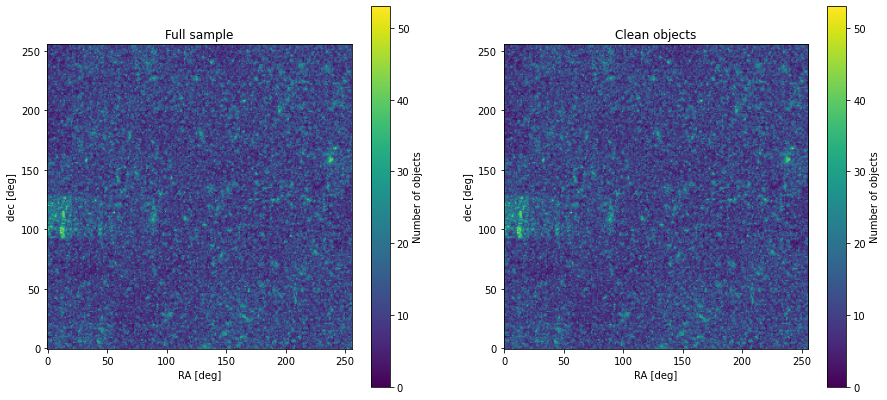

In [50]:
def hist2d(partition, nbins=256, xyrange=None):
    """ Produce 2D histograms from (x, y) data
    
    Parameters
    ----------
    partition : Iterator
        Iterator containing partition data *[x, y].
        
    Returns
    ----------
    Generator yielding counts for each partition. 
    Counts is an array of dimension nbins x nbins.
    """
    # Unwrap the iterator
    radec = [*partition]
    ra, dec = np.transpose(radec)
    
    (counts, xedges, yedges, Image) = plt.hist2d(
        ra, dec, nbins, 
        range=xyrange)
    
    yield counts

# Min/Max values - just to make a nice plot
xyrange = [[np.min(xe), np.max(xe)], [np.min(ye), np.max(ye)]]

plt.figure(figsize=(15, 7))
for index, dataframe in enumerate([df_full, df_cut]):
    plt.subplot(121 + index)
    # This is the crucial part - build the plot data in parallel!
    im = dataframe\
        .rdd\
        .mapPartitions(lambda partition: hist2d(partition, 256, xyrange))\
        .reduce(lambda x, y: x+y)
    
    plt.imshow(im.T, origin='lower', aspect='equal');
    plt.xlabel('RA [deg]');
    plt.ylabel('dec [deg]');
    if index == 0:
        plt.title('Full sample');
    else:
        plt.title('Clean objects');
    plt.colorbar(label='Number of objects');

Let's time it and compare that to the previous method:

In [46]:
%time data = df_cut.collect()

CPU times: user 2.88 s, sys: 132 ms, total: 3.01 s
Wall time: 3.47 s


In [47]:
%time data = df_cut.rdd.mapPartitions(lambda partition: hist2d(partition, xyrange)).reduce(lambda x, y: x+y)

CPU times: user 157 ms, sys: 24.1 ms, total: 181 ms
Wall time: 3.88 s


User time is factor of 30 faster (and the volume of data is not big!), for the same total wall time. Definitely the way to go!

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the [`CModel` magnitude](https://www.sdss.org/dr12/algorithms/magnitudes/#cmodel) is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B) section 4.9.10

**Note** JP writing: I couldn't find the counterpart of `{band}_modelfit_CModel_flux` in dpdd files. So just for the sake of the exercise, I used `magerr_{band}_cModel`.

In [48]:
# Subset of columns of interest
cols = "mag_g_cModel, mag_r_cModel, mag_i_cModel"

# SQL - register first the DataFrame
df.createOrReplaceTempView("full_tract")

# Used to be g_modelfit_CModel_flux
sql_command = """
    SELECT {}
    FROM full_tract 
    WHERE 
        tract == 4849 AND
        clean AND
        magerr_g_cModel>0 AND
        magerr_g_cModel<1e16 AND
        magerr_r_cModel>0 AND
        magerr_r_cModel<1e16 AND
        magerr_i_cModel>0 AND
        magerr_i_cModel<1e16
""".format(cols)

# Execute the expression - return a DataFrame
df_sub = spark.sql(sql_command)

print(df_sub.count())

528468


So now, we have selected what we think are stars. Let's take a look at the colors of these objects

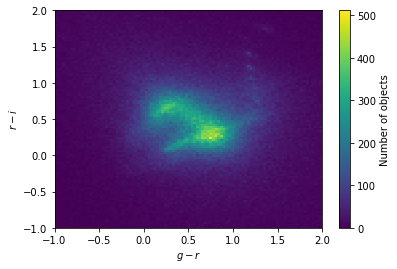

In [49]:
mag_g_cModel, mag_r_cModel, mag_i_cModel = np.transpose(df_sub.collect())
plt.hist2d(mag_g_cModel - mag_r_cModel,
           mag_r_cModel - mag_i_cModel, 
           bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')
plt.colorbar(label='Number of objects');

__More on Apache Spark to come!__